In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from skimage import io, color

import time
import os
import pickle

import matplotlib.pyplot as plt
import scikitplot as skplt

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P40


# Baseline

In [3]:
resnet152 = models.resnet152(pretrained=True)
resnet152 = models.resnet152(num_classes=2)

# Data loading

In [4]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364, 364]),
        transforms.RandomResizedCrop(320),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364,364]),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [5]:
class ChestXray(Dataset):

    def __init__(self, csv_file, image_root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.image_root_dir = image_root_dir
        self.image_path = self.data_frame['image_index']
        self.transform = transform
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        image_filename = self.image_root_dir + self.image_path[index]
        image = io.imread(image_filename, as_gray=True)
        
        sample = {}
        
        # need to transpose: input size for ToPILImage() is H*W*C not C*H*W
        image = np.repeat(image[None,...], 3, axis=0).transpose(1, 2, 0)
        
        if self.transform:
            image = self.transform(np.uint8(image))

        sample['image'] = image
        
        label_col_names = ['normal', 'pneumonia']
        
        sample['label'] = torch.LongTensor([self.data_frame['label'][index]])
        
        return sample

In [6]:
def train(epoch, model, optimizer, criterion, loader, device):
    
    model.train()

    running_loss = 0.0
    epoch_loss = 0.0
    total_samples = 0
    correct = 0 

    for batch_idx, samples in enumerate(loader):
        
        image = samples['image'].to(device)
        label = samples['label'].squeeze()
        label = torch.tensor(label, dtype=torch.long, device=device)
        
        preds = model(image)        
        
        loss = train_criterion(preds, label)
        running_loss += loss.item()
        epoch_loss += loss.item()
        
        total_samples += image.shape[0]
        correct += torch.sum(torch.max(preds, dim=1)[1] == label).item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss = 0.0

    training_accuracy = correct / total_samples

    return epoch_loss / len(loader), training_accuracy

In [26]:
def validation(model, optimizer, criterion, loader, device):
    
    model.eval()

    running_loss = 0.0
    epoch_loss = 0.0
    total_samples = 0
    correct = 0 
        
    for batch_idx, samples in enumerate(loader):
        
        image = samples['image'].to(device)
        label = samples['label'].squeeze()
        label = torch.tensor(label, dtype=torch.long, device=device)

        preds = model(image)        

        loss = valid_criterion(preds, label)
        running_loss += loss.item()
        epoch_loss += loss.item()

        total_samples += image.shape[0]
        correct += torch.sum(torch.max(preds, dim=1)[1] == label).item()

        running_loss = 0.0

    validation_accuracy = correct / total_samples

    return epoch_loss / len(loader), validation_accuracy

In [25]:
# # local
# train_df_path = '../../chest_xray_origin/train.csv'
# val_df_path = '../../chest_xray_origin/val.csv'
# root_dir = '../../chest_xray_origin/all/'

# hpc
train_df_path = 'chest_xray_origin/train.csv'
val_df_path = 'chest_xray_origin/val.csv'
root_dir = 'chest_xray_origin/all/'

train_transformed = ChestXray(train_df_path, root_dir)
val_transformed = ChestXray(val_df_path, root_dir)

bs = 10
epochs = 20

In [10]:
train_loader = DataLoader(ChestXray(train_df_path, root_dir, transform=train_transform), batch_size=bs, shuffle=True)
valid_loader = DataLoader(ChestXray(val_df_path, root_dir, transform=validation_transform), batch_size=bs, shuffle=False)    
                                                         
model = resnet152

model.to(device)

# weighted cross entropy loss: normal, pneumonia
train_weights = train_loader.dataset.data_frame.shape[0] / np.array(train_loader.dataset.data_frame['class'].value_counts())[::-1]
valid_weights = valid_loader.dataset.data_frame.shape[0] / np.array(valid_loader.dataset.data_frame['class'].value_counts())[::-1]

train_weights = torch.FloatTensor(train_weights).to(device)
valid_weights = torch.FloatTensor(valid_weights).to(device)

train_criterion = nn.CrossEntropyLoss(weight=train_weights)
valid_criterion = nn.CrossEntropyLoss(weight=valid_weights)

optimizer = optim.Adam(model.parameters())

criterions = []

history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}

best_val_loss = np.inf

# training process
start_epoch = 1
for epoch in range(start_epoch, epochs + 1):

    train_loss, train_acc = train(epoch, model, optimizer, train_criterion, train_loader, device) #), args.log_interval, append_line_to_log, checkPath)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    print('epoch: ', epoch)
    print('{}: train loss: {:.4f} Acc: {:.4f}'.format('training', train_loss, train_acc))

    valid_loss, valid_acc = validation(epoch, model, optimizer, valid_criterion, valid_loader, device) #, append_line_to_log)
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    
    print('{}: valid loss: {:.4f} Acc: {:.4f}'.format('validation', valid_loss, valid_acc))
    print()

    # save models
    is_best = valid_loss < best_val_loss
    best_val_loss = min(valid_loss, best_val_loss)

    if is_best:
        best_model_file = "best_models/best_model_" + str(epoch) + ".pth"
        torch.save(model.state_dict(), best_model_file)

    model_file = "models/model_" + str(epoch) + ".pth"

    torch.save(model.state_dict(), model_file)

/home/yz6126/pyenv/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch:  1
training: train loss: 0.6445 Acc: 0.6550
validation: valid loss: 3.4941 Acc: 0.6465

epoch:  2
training: train loss: 0.5441 Acc: 0.7439
validation: valid loss: 0.6083 Acc: 0.6306

epoch:  3
training: train loss: 0.4809 Acc: 0.7907
validation: valid loss: 0.4455 Acc: 0.8280

epoch:  4
training: train loss: 0.4632 Acc: 0.7953
validation: valid loss: 0.3536 Acc: 0.8599

epoch:  5
training: train loss: 0.4981 Acc: 0.7705
validation: valid loss: 0.4724 Acc: 0.8217

epoch:  6
training: train loss: 0.4491 Acc: 0.8144
validation: valid loss: 0.4023 Acc: 0.7962

epoch:  7
training: train loss: 0.4358 Acc: 0.8083
validation: valid loss: 0.3663 Acc: 0.8280

epoch:  8
training: train loss: 0.4846 Acc: 0.7854
validation: valid loss: 0.4661 Acc: 0.7293

epoch:  9
training: train loss: 0.4527 Acc: 0.8079
validation: valid loss: 0.5116 Acc: 0.7866

epoch:  10
training: train loss: 0.4506 Acc: 0.8129
validation: valid loss: 0.4622 Acc: 0.7994

epoch:  11
training: train loss: 0.4313 Acc: 0.81

In [3]:
with open("history_resnet.pkl", "wb") as fout:
    pickle.dump(history, fout)

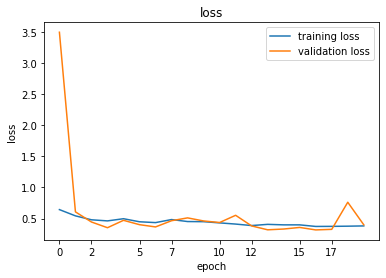

In [11]:
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['valid_loss'], label='validation loss')
plt.legend()
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')

xint = []
locs, labels = plt.xticks()
for each in locs:
    xint.append(int(each))
plt.xticks(xint)
plt.autoscale()

plt.show()

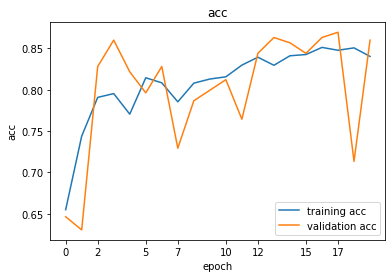

In [12]:
plt.plot(history['train_acc'], label='training acc')
plt.plot(history['valid_acc'], label='validation acc')
plt.legend()
plt.title('acc')
plt.xlabel('epoch')
plt.ylabel('acc')

plt.xticks(xint)
plt.autoscale()

plt.show()

In [3]:
resnet152_test = models.resnet152(pretrained=True)
resnet152_test = models.resnet152(num_classes=2)
resnet152_test.load_state_dict(torch.load('best_models/best_model_17.pth'))
model = resnet152_test
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364,364]),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_df_path = 'chest_xray_origin/test.csv'

root_dir = 'chest_xray_origin/all/'
bs=10

test_loader = DataLoader(ChestXray(test_df_path, root_dir, transform=test_transform), batch_size=bs, shuffle=False)    

test_weights = test_loader.dataset.data_frame.shape[0] / np.array(test_loader.dataset.data_frame['class'].value_counts())[::-1]
test_weights = torch.FloatTensor(test_weights).to(device)
test_criterion = nn.CrossEntropyLoss(weight=test_weights)

optimizer = optim.Adam(model.parameters())

In [26]:
def test(model, optimizer, criterion, loader, device):

    model.eval()

    running_loss = 0.0
    total_samples = 0
    correct = 0
    mysoftmax = nn.Softmax(dim=1)

    preds_list = []
    truelabels_list = []
    probas_list = []
    with torch.no_grad():
        for batch_idx, samples in enumerate(loader):

            image = samples['image'].to(device)
            label = samples['label'].squeeze()
            label = torch.tensor(label, dtype=torch.long, device=device)

            output = model(image)
            output_softmax = mysoftmax(output)

            _, preds = torch.max(output, dim = 1)

            loss = test_criterion(output, label)
            running_loss += loss.item()

            total_samples += image.shape[0]
            correct += torch.sum(preds == label).item()


            preds_list.append(preds.cpu().numpy())
            truelabels_list.append(label.cpu().numpy())
            probas_list.append(output_softmax.cpu().numpy())

        test_accuracy = correct / total_samples

        return running_loss / len(loader), test_accuracy, preds_list, truelabels_list, probas_list


In [27]:
history_resnet_test = {"test_loss":[], "test_acc":[], "preds_list":[], "truelabels_list":[], "proabs_list":[]}

test_loss, test_acc, preds_list, truelabels_list, proabs_list= test(model, optimizer, test_criterion, test_loader, device)
history_resnet_test["test_loss"].append(test_loss)
history_resnet_test["test_acc"].append(test_acc)
history_resnet_test["preds_list"].append(preds_list)
history_resnet_test["truelabels_list"].append(truelabels_list)
history_resnet_test["proabs_list"].append(proabs_list)

print('{}: test loss: {:.4f} Acc: {:.4f}'.format('test', test_loss, test_acc))
print()

/home/yz6126/pyenv/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test: test loss: 0.5097 Acc: 0.7935



In [39]:
with open("history_resnet_test.pkl", "wb") as fout:
    pickle.dump(history_resnet_test, fout)

In [29]:
proabs_stacked = np.vstack(proabs_list)
true_labels = np.concatenate(truelabels_list)
pred_labels = np.concatenate(preds_list)

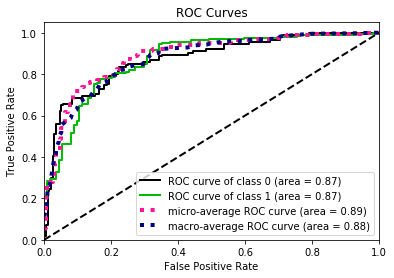

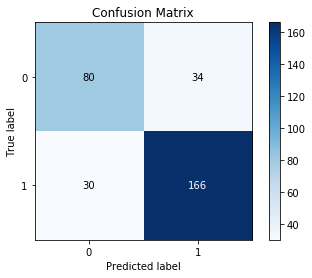

In [38]:
skplt.metrics.plot_roc(true_labels, proabs_stacked)
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels)